In [1]:
# Celda 1 — Warnings, imports y paths
import warnings, os, sys, json
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from tqdm.auto import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import mlflow

# Paths
CURATED = "../data/curated/ecobici_model_ready.parquet"
REPORTS_DIR = "../reports"
EXPERIMENT  = "ecobici_backtest_rf"
os.makedirs(REPORTS_DIR, exist_ok=True)

# Columnas clave
Y_COL  = "num_bikes_available"
ID_COL = "station_id"
TS_COL = "ts_local"

# MLflow local
mlflow.set_tracking_uri("mlruns")
mlflow.set_experiment(EXPERIMENT)

print("OK — entorno listo")

2025/10/24 21:19:05 INFO mlflow.tracking.fluent: Experiment with name 'ecobici_backtest_rf' does not exist. Creating a new experiment.


OK — entorno listo


In [2]:
# Celda 2 — Utilidades (preprocess + make_X_y)
def _looks_like_json_dict(s: str) -> bool:
    s = str(s).strip()
    return s.startswith("{") and s.endswith("}")

def expand_json_like_columns(df: pd.DataFrame, exclude: list[str]) -> pd.DataFrame:
    df2 = df.copy()
    obj_cols = [c for c in df2.columns if c not in exclude and df2[c].dtype == "object"]
    for col in obj_cols:
        sample = df2[col].dropna().astype(str).head(50)
        if len(sample) == 0:
            continue
        if sample.map(_looks_like_json_dict).mean() >= 0.6:
            def _parse(x):
                try:
                    d = json.loads(x) if isinstance(x, str) else x
                    return d if isinstance(d, dict) else {}
                except Exception:
                    return {}
            exp = df2[col].apply(_parse).apply(pd.Series)
            if exp is not None and exp.shape[1] > 0:
                exp = exp.add_prefix(f"{col}_")
                for c in exp.columns:
                    exp[c] = pd.to_numeric(exp[c], errors="coerce").fillna(0.0)
                df2 = pd.concat([df2.drop(columns=[col]), exp], axis=1)
    return df2

def make_X_y(df: pd.DataFrame, y_col: str, id_col: str, ts_col: str):
    drop_cols = [c for c in [y_col, id_col, ts_col] if c in df.columns]
    X = df.drop(columns=drop_cols, errors="ignore").copy()
    X = expand_json_like_columns(X, exclude=[])
    # One-hot conservador (cardinalidad baja)
    low = [c for c in X.columns if X[c].dtype == "object" and X[c].nunique(dropna=True) <= 20]
    if low:
        X = pd.get_dummies(X, columns=low, drop_first=True)
    X = X.select_dtypes(include=["number"]).fillna(0.0)
    y = df[y_col].astype(float).copy()
    return X, y

def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df[TS_COL] = pd.to_datetime(df[TS_COL], errors="coerce")
    df = df.dropna(subset=[TS_COL]).sort_values([ID_COL, TS_COL]).reset_index(drop=True)
    return df

In [3]:
# Celda 3 — Cargar dataset canónico
assert os.path.exists(CURATED), f"No existe {CURATED}"
df_all = preprocess(pd.read_parquet(CURATED))
df_all[[ID_COL, TS_COL, Y_COL]].head()

,station_id,ts_local,num_bikes_available
0,2,2025-10-03 08:54:39-03:00,7
1,2,2025-10-03 08:57:40-03:00,7
2,2,2025-10-03 09:00:41-03:00,7
3,2,2025-10-03 09:03:42-03:00,7
4,2,2025-10-03 09:06:42-03:00,5


In [4]:
# Celda 4 — Generador de splits temporales (backtesting simple)
#- Usa expanding window con 3–5 cortes.
#- Mantiene cronología global; no mezcla futuro y pasado.

def make_time_splits(df: pd.DataFrame, ts_col: str, n_splits: int = 3,
                     p_train_start: float = 0.50, p_train_end: float = 0.75,
                     p_val: float = 0.15):
    """
    Genera n_splits con train creciente (expanding) y val fija (p_val) sobre el timeline global.
    p_train_start → tamaño de train en el primer split
    p_train_end   → tamaño de train en el último split (≈ 75% por defecto)
    """
    tsu = df[ts_col].sort_values().unique()
    n = len(tsu)
    trains = np.linspace(p_train_start, p_train_end, n_splits)
    for i, p_tr in enumerate(trains, start=1):
        cut_tr_end = tsu[int(n * p_tr)]
        cut_val_end = tsu[min(n - 1, int(n * (p_tr + p_val)))]
        tr = df[df[ts_col] <= cut_tr_end].copy()
        va = df[(df[ts_col] > cut_tr_end) & (df[ts_col] <= cut_val_end)].copy()
        # si la val quedó vacía (ej. al final), se salta
        if len(va) == 0:
            continue
        yield i, tr, va, cut_tr_end, cut_val_end

In [5]:
# Celda 5 — Config del modelo base (mismo que Etapa 3)
SEED = 42
RF_PARAMS = dict(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    random_state=SEED,
    n_jobs=-1
)
RF_PARAMS

{'n_estimators': 300,
 'max_depth': None,
 'min_samples_split': 2,
 'random_state': 42,
 'n_jobs': -1}

In [6]:
# Celda 6 — Backtesting + MLflow (una corrida por split)
summary = []
artifact_rows = []

for i, tr, va, cut_tr_end, cut_val_end in tqdm(make_time_splits(df_all, TS_COL, n_splits=3), total=3, desc="Backtesting"):
    Xtr, ytr = make_X_y(tr, Y_COL, ID_COL, TS_COL)
    Xva, yva = make_X_y(va, Y_COL, ID_COL, TS_COL)

    # baseline persistente si existe y_lag1
    base_rmse = base_mae = base_r2 = None
    if "y_lag1" in Xva.columns:
        yhat_b = Xva["y_lag1"].values
        base_rmse = mean_squared_error(yva, yhat_b, squared=False)
        base_mae  = mean_absolute_error(yva, yhat_b)
        base_r2   = r2_score(yva, yhat_b)

    # modelo
    rf = RandomForestRegressor(**RF_PARAMS).fit(Xtr, ytr)
    pred = rf.predict(Xva)
    rmse = mean_squared_error(yva, pred, squared=False)
    mae  = mean_absolute_error(yva, pred)
    r2   = r2_score(yva, pred)

    # guardar predicciones del split (muestra)
    preds_df = pd.DataFrame({
        "ts": va[TS_COL].values,
        "station_id": va[ID_COL].values,
        "y_true": yva.values,
        "y_pred": pred
    }).sort_values(["station_id","ts"]).head(50)  # muestra chica para artefacto
    art_path = os.path.join(REPORTS_DIR, f"backtest_split{i}_sample_preds.csv")
    preds_df.to_csv(art_path, index=False)

    # MLflow: 1 run por split
    with mlflow.start_run(run_name=f"bt_split_{i}") as run:
        mlflow.log_param("split_id", i)
        mlflow.log_param("cut_train_end", str(cut_tr_end))
        mlflow.log_param("cut_val_end", str(cut_val_end))
        for k, v in RF_PARAMS.items():
            mlflow.log_param(k, v)

        mlflow.log_metric("val_rmse", rmse)
        mlflow.log_metric("val_mae",  mae)
        mlflow.log_metric("val_r2",   r2)
        if base_rmse is not None:
            mlflow.log_metric("baseline_rmse", base_rmse)
            mlflow.log_metric("baseline_mae",  base_mae)
            mlflow.log_metric("baseline_r2",   base_r2)

        mlflow.log_artifact(art_path)

    summary.append({
        "split": i,
        "train_end": cut_tr_end,
        "val_end": cut_val_end,
        "val_rmse": rmse,
        "val_mae": mae,
        "val_r2": r2,
        "baseline_rmse": base_rmse,
        "baseline_mae": base_mae,
        "baseline_r2": base_r2
    })

bt = pd.DataFrame(summary)
bt_path = os.path.join(REPORTS_DIR, "backtest_summary.csv")
bt.to_csv(bt_path, index=False)
bt

Backtesting:   0%|          | 0/3 [00:00<?, ?it/s]

,split,train_end,val_end,val_rmse,val_mae,val_r2,baseline_rmse,baseline_mae,baseline_r2
0,1,2025-10-05 16:29:37-03:00,2025-10-05 20:41:56-03:00,0.000000,0.000000,1.000000,0.274686,0.049300,0.996639
1,2,2025-10-05 19:59:20-03:00,2025-10-06 14:52:52-03:00,0.000429,0.000009,1.000000,0.627367,0.136809,0.983082
2,3,2025-10-06 14:10:04-03:00,2025-10-06 18:25:49-03:00,0.197288,0.005653,0.998426,0.558007,0.226062,0.987409


,split,val_rmse,val_mae,val_r2,baseline_rmse,baseline_mae,baseline_r2
count,3.0,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,2.0,0.065905,0.001887,0.999475,0.486687,0.137390,0.989044
std,1.0,0.113781,0.003261,0.000909,0.186845,0.088382,0.006925
min,1.0,0.000000,0.000000,0.998426,0.274686,0.049300,0.983082
25%,1.5,0.000214,0.000005,0.999213,0.416346,0.093054,0.985246
50%,2.0,0.000429,0.000009,1.000000,0.558007,0.136809,0.987409
75%,2.5,0.098858,0.002831,1.000000,0.592687,0.181435,0.992024
max,3.0,0.197288,0.005653,1.000000,0.627367,0.226062,0.996639


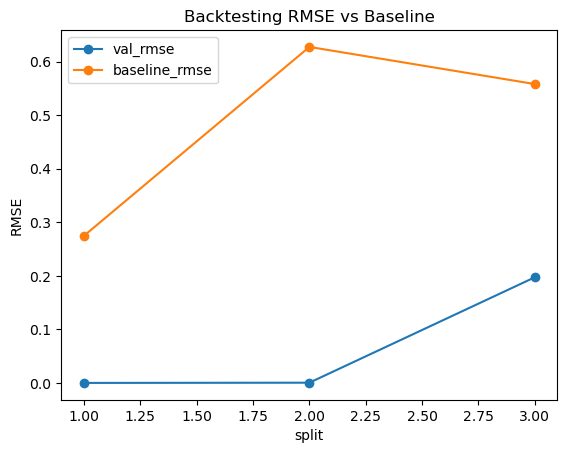

In [7]:
# Celda 7 — Resumen y gráfico rápido (opcional)
display(bt.describe())
try:
    ax = bt.set_index("split")[["val_rmse","baseline_rmse"]].plot(marker="o", title="Backtesting RMSE vs Baseline")
    ax.set_ylabel("RMSE")
except Exception as e:
    print("Plot opcional omitido:", e)

In [8]:
# Celda 8 — Monitoreo mínimo (estabilidad/disponibilidad)

#Checks rápidos que ayudan a detectar drift/agotamiento de estaciones:
#- KS test de y_lag1 entre la primera y última ventana.
#- % de timestamps con y==0 por estación (alerta de saturación).

from scipy.stats import ks_2samp

# Tomo la primera y última ventana de validación
if len(summary) >= 2:
    first_cut = summary[0]["val_end"]
    last_cut  = summary[-1]["val_end"]

    early = df_all[df_all[TS_COL] <= first_cut]
    late  = df_all[(df_all[TS_COL] > last_cut - (last_cut - first_cut)) & (df_all[TS_COL] <= last_cut)]

    # KS sobre y_lag1 cuando exista
    cols = [c for c in df_all.columns if c == "y_lag1"]
    drift_rows = []
    if cols:
        e = early["y_lag1"].dropna().astype(float)
        l = late["y_lag1"].dropna().astype(float)
        if len(e) > 100 and len(l) > 100:
            ks = ks_2samp(e, l)
            drift_rows.append({"feature":"y_lag1", "ks_stat": ks.statistic, "pvalue": ks.pvalue})
    drift_df = pd.DataFrame(drift_rows)

    # % de ceros por estación (posible saturación)
    zeros = (
        df_all.groupby(ID_COL)[Y_COL]
        .apply(lambda s: (s==0).mean())
        .reset_index(name="p_zero")
        .sort_values("p_zero", ascending=False)
    )

    mon_path = os.path.join(REPORTS_DIR, "monitoring_quickcheck.csv")
    with open(mon_path, "w") as f:
        f.write("# Quick monitoring checks\n")
    zeros.to_csv(mon_path, mode="a", index=False)
    if not drift_df.empty:
        with open(mon_path, "a") as f:
            f.write("\n# KS drift (early vs late) sobre y_lag1\n")
        drift_df.to_csv(mon_path, mode="a", index=False)

    print("Monitoreo guardado en:", mon_path)
    display(zeros.head(10))
    display(drift_df if not drift_df.empty else "Sin KS (muestras insuficientes o sin y_lag1)")
else:
    print("No se generaron ≥2 splits: monitoreo simplificado omitido.")

Monitoreo guardado en: ../reports/monitoring_quickcheck.csv


,station_id,p_zero
344,541,0.584071
251,420,0.570397
85,132,0.555950
276,464,0.508834
389,589,0.490809
212,355,0.479501
31,50,0.469298
118,186,0.465364
215,361,0.464539
35,58,0.449458


,feature,ks_stat,pvalue
0,y_lag1,0.028538,2.631723e-28


In [ ]:
# Celda 9 — (Opcional) DVC mínimo para versionar artefactos

#Ejecutá estas celdas solo si tenés dvc inicializado (dvc init).
#Podés correrlas como comandos de shell con !, o copiar a tu terminal.

# Verificar DVC
# !dvc --version

# Versionar dataset y reportes clave (una vez)
# !dvc add ../data/raw/status_clean.parquet
# !dvc add ../reports/backtest_summary.csv

# Commit en git
# !git add ../data/raw/status_clean.parquet.dvc ../reports/backtest_summary.csv.dvc
# !git commit -m "Track raw y backtest summary con DVC"

# Configurar y empujar a un remote (ej. DagsHub/S3) — una vez:
# !dvc remote add -d origin s3://<tu-bucket>/ecobici
# !dvc push

Qué mirar:
- reports/backtest_summary.csv  → estabilidad de RMSE/MAE en las ventanas
- MLflow (make mlflow-ui)       → runs por split con params, métricas y artefactos
- reports/monitoring_quickcheck.csv → % de ceros por estación y (si hubo) KS sobre y_lag1

Siguiente:
- Si el modelo es estable → avanzar a Etapa 6 (AutoML) y comparar contra baseline.
- Luego, elegir mejor candidato y llevarlo al Paso 4 (predict_batch) y dashboard.


📝 Notas rápidas
- Reproducibilidad: el RF usa random_state=42.
- Comparación honesta: la baseline y_lag1 te da un piso; si tu modelo no la supera, hay que revisar features.
- MLflow UI: corré make mlflow-ui (si ya agregaste ese target) y abrí http://127.0.0.1:5000.
- DVC: mantené versionado el raw y los reports principales; el resto (curated/splits) los podés sumar luego.


### Explicación de este notebook

Perfecto. Te explico paso a paso qué hace este notebook de Etapa 5 – Evaluación & Tracking (Backtesting + MLflow + DVC + Monitoreo) y por qué es una parte clave de tu pipeline Ecobici-AutoML.
La idea es que entiendas qué está midiendo, cómo, y por qué lo hacemos antes del AutoML.

⸻

🧩 1. ¿Qué hace este notebook?

Este notebook evalúa la estabilidad temporal y la calidad predictiva de tu modelo base (por ejemplo, el RandomForest que entrenaste en la Etapa 3) a lo largo del tiempo, usando una técnica llamada backtesting.
Además, registra automáticamente los resultados y parámetros en MLflow (para trazabilidad de experimentos) y deja un control mínimo de monitoreo de datos (para detectar drift o anomalías).

En resumen, este notebook te responde tres preguntas:

|Pregunta	|Qué mide	|Dónde mirar |
|-----------|-----------|------------|
|🕐 ¿Mi modelo mantiene su rendimiento a lo largo del tiempo?	| Estabilidad de RMSE, MAE, R² por ventana temporal	|reports/backtest_summary.csv |
|📊 ¿Qué resultados y parámetros tuvo cada corrida?	| Métricas y artefactos por split	|UI de MLflow (make mlflow-ui) |
|🧠 ¿El comportamiento de los datos cambió con el tiempo?	|Drift, saturación (p. ej. estaciones siempre vacías)	|reports/monitoring_quickcheck.csv |


⸻

🔁 2. ¿Qué es el backtesting?

Backtesting es una técnica que viene del mundo financiero y del análisis de series temporales.
Consiste en simular cómo se habría comportado tu modelo si lo hubieras entrenado y probado en diferentes momentos del pasado, para verificar si sus resultados son estables y no dependen de una única ventana temporal.

🧠 Concepto simple:

Imaginá que tus datos cubren de enero 2024 a octubre 2025.
En vez de entrenar una sola vez con 2024 → test 2025, haces algo como esto:

|Split	|Train hasta	|Validación siguiente	|Qué mide |
|-------|---------------|-----------------------|---------|
|1	|Jun 2024	|Ago 2024	|rendimiento temprano |
|2	|Dic 2024	|Feb 2025	|rendimiento medio |
|3	|Jun 2025	|Ago 2025	|rendimiento reciente |

Cada split avanza la ventana temporal, entrenando con más datos pasados y validando en un bloque de tiempo futuro cercano.

Así podés ver si el RMSE o el R² se mantienen estables o si el modelo se degrada con el tiempo (lo que indica posible drift de datos o pérdida de vigencia).

⸻

🧾 3. ¿Cómo lo implementa este notebook?

1.	Carga el dataset canónico (data/curated/ecobici_model_ready.parquet), ya limpio y con variables derivadas.
2.	Genera splits temporales automáticos con la función make_time_splits, que divide el tiempo total en varias ventanas (por defecto, tres).
3.	Para cada split:
	- Entrena un RandomForestRegressor con los datos hasta el corte de train.
	- Evalúa en la ventana siguiente (validación).
	- Calcula métricas: RMSE, MAE, R².
	- Calcula también un baseline: la predicción “persistente” (y_lag1), útil como piso de comparación.
	- Guarda una muestra de predicciones y loguea todo en MLflow como un run independiente.
4.	Guarda un resumen global (backtest_summary.csv) con los resultados de cada ventana.
5.	Realiza un chequeo básico de monitoreo:
	- Evalúa si hay drift (cambio de distribución) en y_lag1 usando un test KS.
	- Detecta estaciones que tienen un alto porcentaje de valores en cero (p_zero), posible síntoma de saturación o problemas de disponibilidad.
6.	(Opcional) versiona artefactos con DVC para mantener trazabilidad de datos y reportes.

⸻

📈 4. ¿Qué te aporta MLflow acá?

MLflow actúa como un registro automático de experimentos:
- Guarda parámetros (n_estimators, random_state, etc.)
- Guarda métricas (RMSE, MAE, R², baseline)
- Guarda artefactos (CSV de predicciones por split)

Con make mlflow-ui podés abrir un panel web local (puerto 5000) donde ver:
- Gráficas de métricas por split
- Comparación de runs
- Links a los CSV generados

Esto reemplaza el “anotado manual” de resultados y te deja una bitácora reproducible de tus experimentos.

⸻

🔍 5. ¿Y el monitoreo con DVC?

Una vez que tenés tus resultados, DVC (Data Version Control) permite versionar archivos grandes como datasets o reportes, similar a cómo Git versiona código.
Acá se usa para:
- Guardar versiones de los datasets (data/raw/status_clean.parquet)
- Guardar los reportes clave (backtest_summary.csv)
- Opcionalmente subirlos a un remote (S3, DagsHub, etc.)

Esto te deja una línea de tiempo de los datos y resultados, útil si el modelo se recalibra más adelante.

⸻

🩺 6. ¿Qué información final obtenés?

|Archivo	|Contenido	|Uso posterior |
|-----------|-----------|--------------|
|reports/backtest_summary.csv	|RMSE/MAE/R² por split temporal + baseline	|Analizar estabilidad temporal |
|reports/monitoring_quickcheck.csv	|% de ceros por estación + KS drift	|Control de calidad y alerta de drift |
|mlruns/	R|uns MLflow con parámetros, métricas y artefactos	|Historial de experimentos |
|(opcional) |.dvc |files	|Versionado de datasets y reportes	|Reproducibilidad en el tiempo |


⸻

🧠 7. ¿Por qué es importante antes del AutoML?

El AutoML (Etapa 6) puede probar muchos modelos, pero no detecta automáticamente si tus datos cambian con el tiempo o si tu baseline ya era suficientemente bueno.
El backtesting te da la base para:
- Saber si tu dataset está estable.
- Detectar períodos donde el modelo se degrada.
- Decidir si vale la pena complejizar el modelo con AutoML.

En otras palabras:

🔍 Etapa 5 valida la solidez temporal del pipeline antes de gastar tiempo en optimizarlo con AutoML.

⸻

¿Querés que te agregue ahora una breve descripción markdown (tipo docstring) para poner al principio del notebook (como Celda #0 “Introducción”)?
Así la copiás directo antes de las celdas de código.